# Change of variables in HMC

This notebook reproduces the hierarchical binomial model from https://github.com/probml/pyprobml/blob/master/notebooks/book2/03/hierarchical_binom_rats.ipynb, but performs HMC inference both with and without a change of variables. The purpose is to illustrate the deleterious effects of forgetting to use bijectors and Jacobians. Note that the blackjax library will not detect such mistakes for you, but we show how to use arviz to diagnose the problem.

In [ ]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option("display.max_rows", 80)

try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq jaxopt blackjax
    import blackjax

try:
    import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow_probability
    import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
plt.rc("xtick", labelsize=12)  # fontsize of the xtick labels
plt.rc("ytick", labelsize=12)  # fontsize of the tyick labels

## Data

In [ ]:
# fmt: off
n_of_positives = jnp.array( [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 2, 5, 3, 2, 7, 7, 3, 3, 2, 9, 10, 4, 4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 5, 11, 12, 5, 5, 6, 5, 6, 6, 6, 6, 16, 15, 15, 9, 4, ], dtype=jnp.float32)
group_size = jnp.array( [ 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20, 20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19, 46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20, 48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46, 47, 24, 14, ], dtype=jnp.float32)
n_rat_tumors = len(group_size)  # number of different kind of rat tumors
# fmt: on

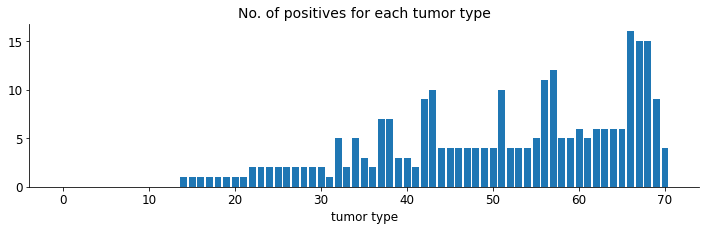

In [ ]:
plt.figure(figsize=(12, 3))
plt.bar(range(n_rat_tumors), n_of_positives)
plt.title("No. of positives for each tumor type", fontsize=14)
plt.xlabel("tumor type", fontsize=12)
sns.despine()

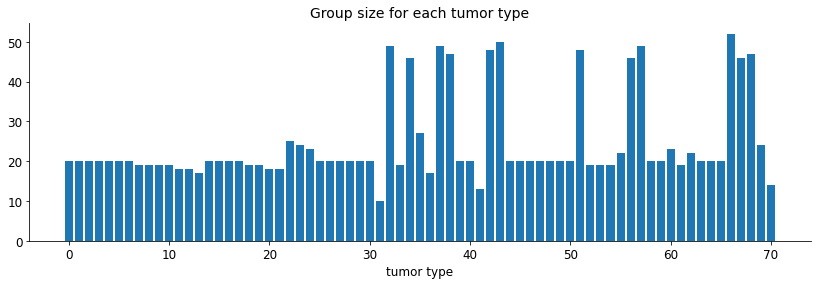

In [ ]:
plt.figure(figsize=(14, 4))
plt.bar(range(n_rat_tumors), group_size)
plt.title("Group size for each tumor type", fontsize=14)
plt.xlabel("tumor type", fontsize=12)
sns.despine()

## Posterior sampling

Now we use Blackjax's NUTS algorithm to get posterior samples of $a$, $b$, and $\theta$ 

In [ ]:
def joint_logprob(params):
    a, b, thetas = params["a"], params["b"], params["thetas"]

    # improper prior for a,b
    logprob_ab = jnp.log(jnp.power(a + b, -2.5))

    # logprob prior of theta
    logprob_thetas = tfd.Beta(a, b).log_prob(thetas).sum()

    # loglikelihood of y
    logprob_y = jnp.sum(
        jax.vmap(lambda y, N, theta: tfd.Binomial(N, probs=theta).log_prob(y))(n_of_positives, group_size, thetas)
    )

    return logprob_ab + logprob_thetas + logprob_y

We take initial parameters from uniform distribution

In [ ]:
rng_key = jax.random.PRNGKey(0)
n_params = n_rat_tumors + 2


def init_param_fn(seed):
    """
    initialize a, b & thetas
    """
    key1, key2 = jax.random.split(seed)
    return {
        "a": tfd.Uniform(0, 3).sample(seed=key1),
        "b": tfd.Uniform(0, 3).sample(seed=key2),
        "thetas": tfd.Uniform(0, 1).sample(n_rat_tumors, seed),
    }


init_param = init_param_fn(rng_key)
joint_logprob(init_param)  # sanity check

DeviceArray(-1241.5929, dtype=float32)

Now we use blackjax's window adaption algorithm to get NUTS kernel and initial states. Window adaption algorithm will automatically configure `inverse_mass_matrix` and `step size`

In [ ]:
%%time
warmup = blackjax.window_adaptation(blackjax.nuts, joint_logprob, 1000)

# we use 4 chains for sampling
n_chains = 4
keys = jax.random.split(rng_key, n_chains)
init_params = jax.vmap(init_param_fn)(keys)

initial_states = jax.vmap(lambda seed, param: warmup.run(seed, param)[0])(keys, init_params)

# can not vectorize kernel, since it is not jax.numpy array
_, kernel, _ = warmup.run(jax.random.PRNGKey(10), init_param_fn(rng_key))

CPU times: user 18.1 s, sys: 283 ms, total: 18.4 s
Wall time: 18.2 s


Now we write inference loop for multiple chains

In [ ]:
def inference_loop_multiple_chains(rng_key, kernel, initial_states, num_samples, num_chains):
    @jax.jit
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, infos = jax.vmap(kernel)(keys, states)
        return states, (states, infos)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_states, keys)

    return (states, infos)

In [ ]:
%%time
n_samples = 1000
states, infos = inference_loop_multiple_chains(rng_key, kernel, initial_states, n_samples, n_chains)

CPU times: user 7.79 s, sys: 55.5 ms, total: 7.85 s
Wall time: 7.77 s


In [ ]:
states.position.keys()

dict_keys(['a', 'b', 'thetas'])

## Arviz plots

We have all our posterior samples stored in `states.position` dictionary and `infos` store additional information like acceptance probability, divergence, etc. Now, we can use certain diagnostics to judge if our MCMC samples are converged on stationary distribution. Some of widely diagnostics are trace plots, potential scale reduction factor (R hat), divergences, etc. `Arviz` library provides quicker ways to anaylze these diagnostics. We can use `arviz.summary()` and `arviz_plot_trace()`, but these functions take specific format (arviz's trace) as a input. So now first we will convert `states` and `infos` into `trace`.

In [ ]:
def arviz_trace_from_states(states, info, burn_in=0):

    if isinstance(states.position, jnp.DeviceArray):  # if states.position is array of samples
        ndims = jnp.ndim(states.position)
        if ndims > 1:
            samples = {"samples": jnp.swapaxes(states.position, 0, 1)}
            divergence = jnp.swapaxes(info.is_divergent, 0, 1)
        else:
            samples = jnp.swapaxes(states.position, 0, 1)
            divergence = info.is_divergent, 0, 1

    else:  # if states.position is dict
        samples = {}
        for param in states.position.keys():
            ndims = len(states.position[param].shape)
            if ndims >= 2:
                samples[param] = jnp.swapaxes(states.position[param], 0, 1)[:, burn_in:]  # swap n_samples and n_chains
                divergence = jnp.swapaxes(info.is_divergent[burn_in:], 0, 1)

            if ndims == 1:
                divergence = info.is_divergent
                samples[param] = states.position[param]

    trace_posterior = az.convert_to_inference_data(samples)
    trace_sample_stats = az.convert_to_inference_data({"diverging": divergence}, group="sample_stats")
    trace = az.concat(trace_posterior, trace_sample_stats)
    return trace

In [ ]:
# make arviz trace from states
trace = arviz_trace_from_states(states, infos)
summ_df = az.summary(trace)
summ_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.746,0.071,0.623,0.837,0.035,0.027,4.0,12.0,3.31
b,2.000,0.340,1.750,2.627,0.169,0.129,5.0,14.0,2.03
thetas[0],0.014,0.019,0.000,0.061,0.009,0.007,6.0,19.0,1.85
thetas[1],0.156,0.103,0.000,0.313,0.051,0.039,4.0,14.0,3.72
thetas[2],0.035,0.020,0.000,0.066,0.008,0.006,6.0,24.0,1.70
thetas[3],0.031,0.028,0.000,0.082,0.006,0.004,20.0,56.0,1.14
thetas[4],0.058,0.042,0.000,0.126,0.009,0.006,26.0,19.0,1.12
thetas[5],0.027,0.027,0.000,0.074,0.007,0.005,15.0,19.0,1.20
thetas[6],0.115,0.127,0.000,0.344,0.063,0.048,5.0,16.0,2.32
thetas[7],0.065,0.049,0.000,0.165,0.024,0.018,5.0,14.0,3.02


**r_hat** is showing measure of each chain is converged to stationary distribution. **r_hat** should be less than or equal to 1.01, here we get r_hat far from 1.01 for each latent sample.

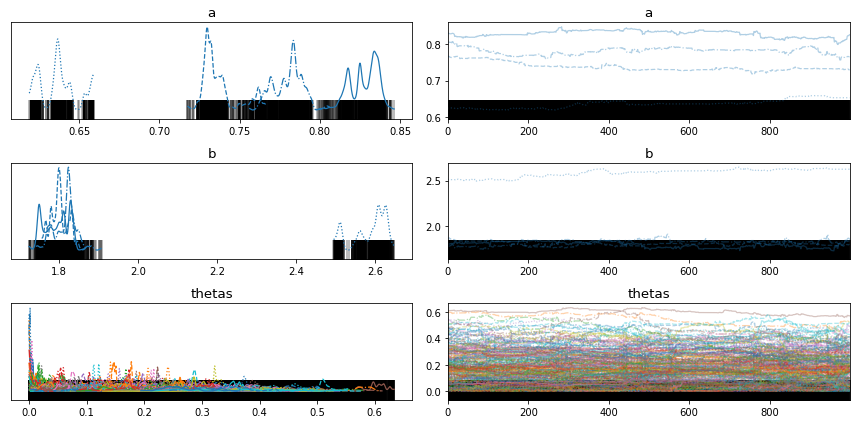

In [ ]:
az.plot_trace(trace)
plt.tight_layout()

Trace plots also looks terrible and does not seems to be converged! Also, black band shows that every sample is diverged from original distribution. So **what's wrong happeing here?**

Well, it's related to support of latent variable. In HMC, the latent variable must be in an unconstrained space, but in above model `theta` is constrained in between 0 to 1. We can use change of variable trick to solve above problem

## Change of variable  
We can sample from logits which is in unconstrained space and in `joint_logprob()` we can convert logits to theta by suitable bijector (sigmoid). We calculate jacobian (first order derivaive) of bijector to tranform one probability distribution to another

In [ ]:
transform_fn = jax.nn.sigmoid
jacobian_fn = lambda logit: jnp.abs(jax.jacfwd(transform_fn)(logit))


def joint_logprob_change_of_var(params):
    a, b, logits = params["a"], params["b"], params["logits"]

    # change of variable
    thetas = transform_fn(logits)
    log_det_jacob = jnp.sum(jax.vmap(lambda logit: jnp.log(jacobian_fn(logit)))(logits))

    # improper prior for a,b
    logprob_ab = jnp.log(jnp.power(a + b, -2.5))

    # logprob prior of theta
    logprob_thetas = tfd.Beta(a, b).log_prob(thetas).sum()

    # loglikelihood of y
    logprob_y = jnp.sum(
        jax.vmap(lambda y, N, theta: tfd.Binomial(N, probs=theta).log_prob(y))(n_of_positives, group_size, thetas)
    )

    return logprob_ab + logprob_thetas + logprob_y + log_det_jacob

except change of variable in `joint_logprob()` function, everthing will remain same

In [ ]:
rng_key = jax.random.PRNGKey(0)
n_params = n_rat_tumors + 2


def init_param_fn(seed):
    """
    initialize a, b & logits
    """
    key1, key2 = jax.random.split(seed)
    return {
        "a": tfd.Uniform(0, 3).sample(seed=key1),
        "b": tfd.Uniform(0, 3).sample(seed=key2),
        "logits": tfd.Uniform(-2, 2).sample(n_rat_tumors, seed),
    }


init_param = init_param_fn(rng_key)
joint_logprob_change_of_var(init_param)  # sanity check

DeviceArray(-1095.3221, dtype=float32)

In [ ]:
%%time
warmup = blackjax.window_adaptation(blackjax.nuts, joint_logprob_change_of_var, 1000)

# we use 4 chains for sampling
n_chains = 4
keys = jax.random.split(rng_key, n_chains)
init_params = jax.vmap(init_param_fn)(keys)

initial_states = jax.vmap(lambda seed, param: warmup.run(seed, param)[0])(keys, init_params)

# can not vectorize kernel, since it is not jax.numpy array
_, kernel, _ = warmup.run(jax.random.PRNGKey(10), init_param_fn(rng_key))

CPU times: user 15.8 s, sys: 334 ms, total: 16.1 s
Wall time: 15.9 s


In [ ]:
%%time
n_samples = 1000
states, infos = inference_loop_multiple_chains(rng_key, kernel, initial_states, n_samples, n_chains)

CPU times: user 8.23 s, sys: 137 ms, total: 8.36 s
Wall time: 8.28 s


In [ ]:
# convert logits samples to theta samples
states.position["thetas"] = jax.nn.sigmoid(states.position["logits"])
del states.position["logits"]  # delete logits

In [ ]:
# make arviz trace from states
trace = arviz_trace_from_states(states, infos, burn_in=0)
summ_df = az.summary(trace)
summ_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.423,0.887,1.008,4.128,0.037,0.028,703.0,640.0,1.01
b,14.448,5.271,5.837,24.424,0.216,0.160,707.0,641.0,1.01
thetas[0],0.064,0.042,0.002,0.139,0.001,0.000,3027.0,2383.0,1.00
thetas[1],0.064,0.041,0.001,0.135,0.001,0.000,3328.0,2528.0,1.00
thetas[2],0.064,0.043,0.001,0.138,0.001,0.001,3211.0,2061.0,1.00
thetas[3],0.064,0.042,0.001,0.139,0.001,0.000,3079.0,2205.0,1.00
thetas[4],0.063,0.040,0.001,0.133,0.001,0.000,2969.0,2100.0,1.00
thetas[5],0.064,0.041,0.002,0.137,0.001,0.000,2902.0,1767.0,1.00
thetas[6],0.063,0.041,0.000,0.136,0.001,0.000,2739.0,1504.0,1.00
thetas[7],0.066,0.043,0.002,0.144,0.001,0.001,2855.0,2096.0,1.00


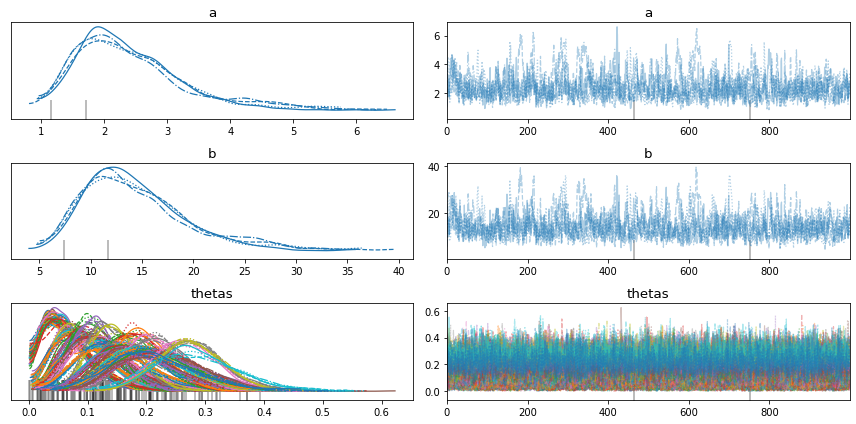

In [ ]:
az.plot_trace(trace)
plt.tight_layout()

In [ ]:
print(f"Number of divergence: {infos.is_divergent.sum()}")

Number of divergence: 2


We can see that **r_hat** is less than or equal to 1.01 for each latent variable, trace plots looks converged to stationary distribution, and only few samples are diverged.